In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

GAN Architecture

In [2]:
def build_generator(latent_dim, img_shape, complexity):
    model = models.Sequential()
    model.add(layers.Dense(complexity, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))
    return model

def build_discriminator(img_shape, complexity):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model


Calculating JSD

In [3]:
def jsd(prob_real, prob_fake):
    """
    Calculate Jensen-Shannon Divergence.
    """
    prob_real = np.clip(prob_real, 1e-10, 1.0)
    prob_fake = np.clip(prob_fake, 1e-10, 1.0)
    m = 0.5 * (prob_real + prob_fake)
    return 0.5 * (entropy(prob_real, m) + entropy(prob_fake, m))

Functions to plot original and constructed images

In [4]:
def plot_original_and_generated_images(generator, epoch, latent_dim, examples=10, dim=(2, 10), figsize=(15, 3)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)  # Adjust for MNIST grayscale images

    # Load original images
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    original_images = X_train[np.random.randint(0, X_train.shape[0], size=examples)]

    plt.figure(figsize=(20, 4))
    for i in range(examples):
        # Plot original image with title
        plt.subplot(dim[0], dim[1], i * 2 + 1)
        plt.imshow(original_images[i], cmap='gray')  # Specify colormap for grayscale images
        plt.title("Original Image", fontsize=8)
        plt.axis('off')

        # Plot generated image with title
        plt.subplot(dim[0], dim[1], i * 2 + 2)
        plt.imshow((generated_images[i] + 1) / 2, cmap='gray', interpolation='nearest')  # Scale back to [0, 1]
        plt.title("Generated Image", fontsize=8)
        plt.axis('off')

Function to plot JSD

In [5]:
def plot_jsd_over_epochs(jsd_values):
    """
    Plot Jenson-Shannon Divergence over epochs.
    """
    plt.figure()
    plt.plot(jsd_values)
    plt.title('Jenson-Shannon Divergence over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('JSD Value')
    plt.show()

Traning GAN

In [6]:
def train_gan(generator, discriminator, gan, epochs, batch_size):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension for grayscale images
    jsd_values = []

    for epoch in range(epochs):
        for _ in range(X_train.shape[0] // batch_size):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

             # Calculate JSD
        noise_real = np.random.normal(0, 1, size=[batch_size, latent_dim])
        generated_images_real = generator.predict(noise_real)
        prob_real = discriminator.predict(image_batch)  # Corrected probability calculation

        noise_fake = np.random.normal(0, 1, size=[batch_size, latent_dim])
        generated_images_fake = generator.predict(noise_fake)
        prob_fake = discriminator.predict(generated_images_fake)  # Corrected probability calculation

        jsd_value = jsd(prob_real, prob_fake)
        jsd_values.append(jsd_value)

        print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]}] [G loss: {g_loss[0]}] [JSD: {jsd_value}]")

    return generator, jsd_values


Setting up general parameter

In [7]:
epochs = 5
batch_size = 128

Behaviour of latent dimensionality values

With latent_dim=5 and complexity=128


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.9874904155731201] [G loss: 0.46900302171707153] [JSD: [0.00313614]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.6248545050621033] [G loss: 0.6907533407211304] [JSD: [0.00958632]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6034169793128967] [G loss: 1.191959023475647] [JSD: [0.03366354]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.5663431882858276] [G loss: 1.5918726921081543] [JSD: [0.04225224]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.5896192789077759] [G loss: 1.0232715606689453] [JSD: [0.02375315]]
1/1 [==============================] - 0s 163ms/step


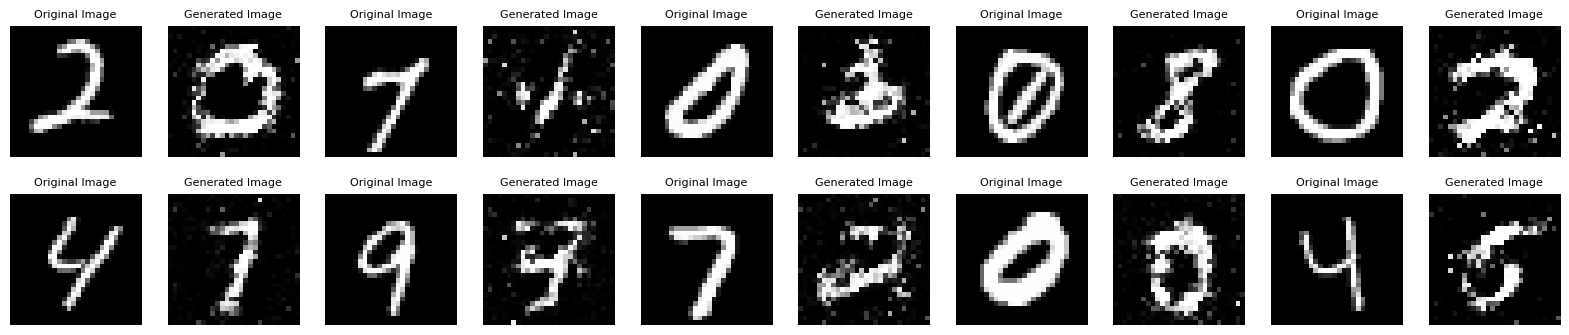

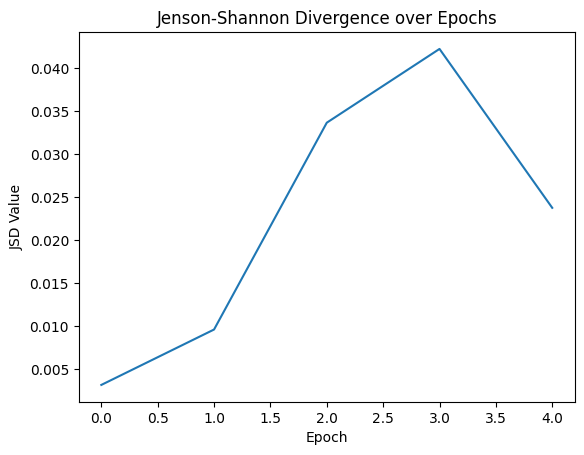

With latent_dim=10 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.560050368309021] [G loss: 0.9846999645233154] [JSD: [0.00641016]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.619254469871521] [G loss: 1.3289780616760254] [JSD: [0.03432871]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.64088374376297] [G loss: 0.8499259948730469] [JSD: [0.01196471]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.6378525495529175] [G loss: 0.8921239972114563] [JSD: [0.0210518]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6222481727600098] [G loss: 0.9729489088058472] [JSD: [0.01912938]]
1/1 [==============================] - 0s 129ms/step


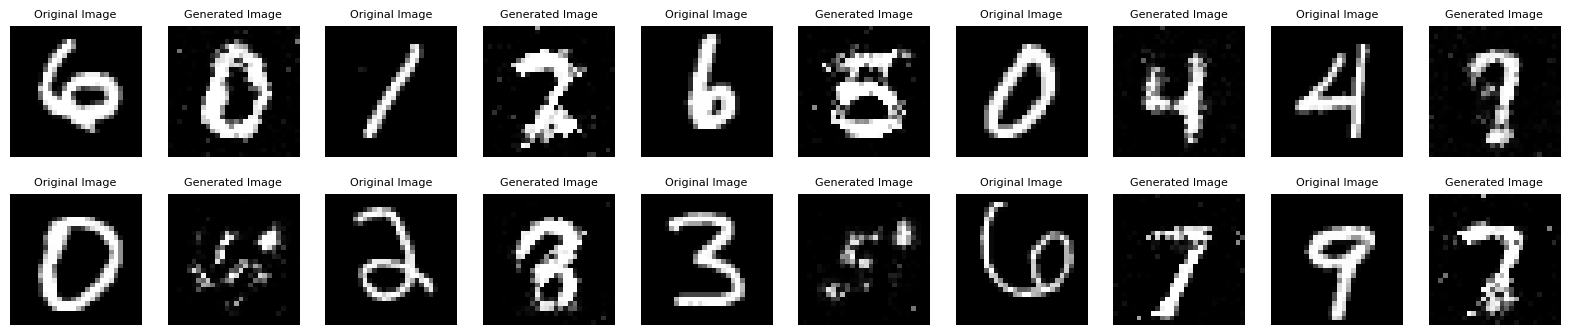

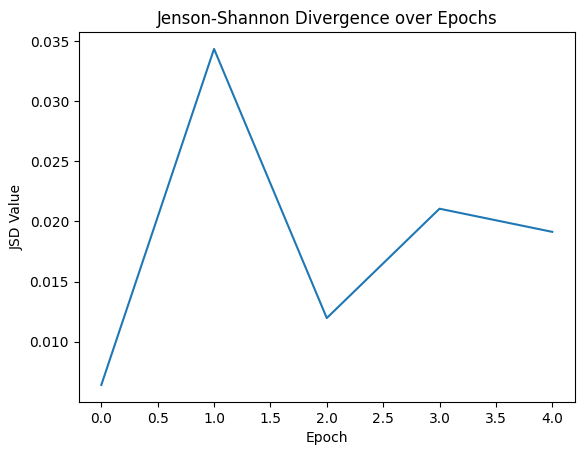

With latent_dim=50 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.5884071588516235] [G loss: 1.05594003200531] [JSD: [0.01040745]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.5536808967590332] [G loss: 1.2325773239135742] [JSD: [0.02590843]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6277053356170654] [G loss: 1.0688056945800781] [JSD: [0.02111373]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.604346752166748] [G loss: 1.0572267770767212] [JSD: [0.02175779]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6449302434921265] [G loss: 0.867573618888855] [JSD: [0.01193599]]
1/1 [==============================] - 0s 127ms/step


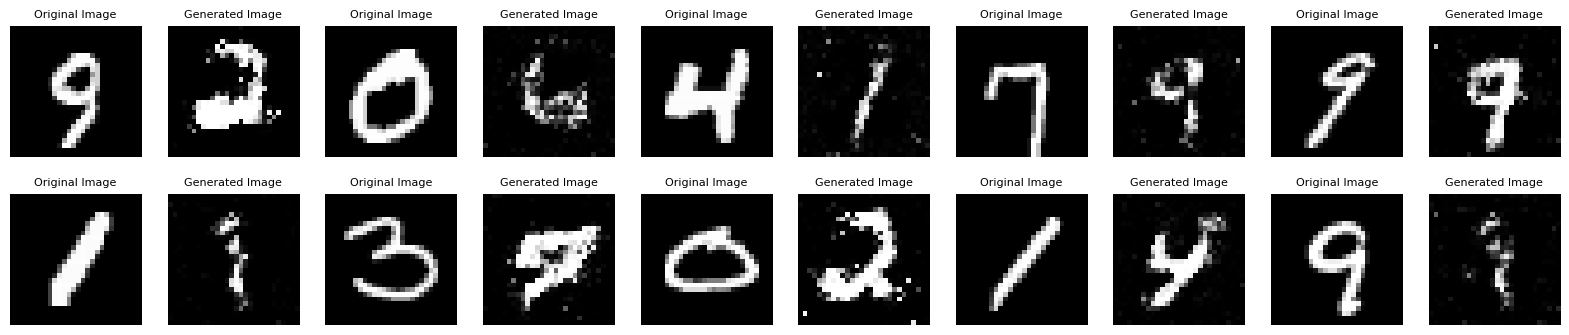

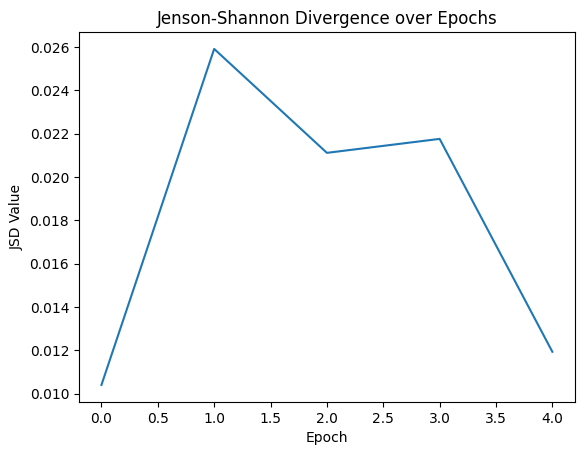

With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.6793408393859863] [G loss: 0.9783626794815063] [JSD: [0.00407258]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.5884292125701904] [G loss: 0.7738054394721985] [JSD: [0.01175544]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6153061389923096] [G loss: 1.228126049041748] [JSD: [0.02940378]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.6242222785949707] [G loss: 1.079032063484192] [JSD: [0.02767764]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.6545625925064087] [G loss: 0.7912543416023254] [JSD: [0.01766293]]
1/1 [==============================] - 0s 127ms/step


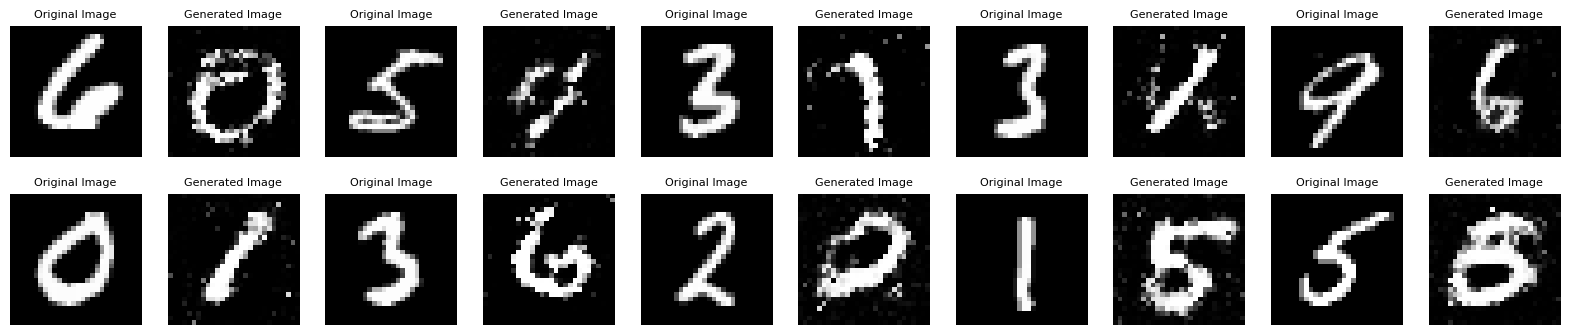

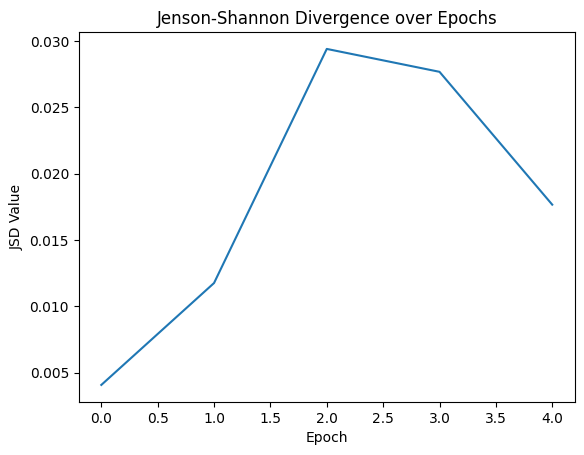

In [8]:
latent_dim_values = [5, 10, 50, 100]
complexity = 128

# Set the image shape for MNIST
img_shape = (28, 28, 1)

for latent_dim in latent_dim_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")
      # Build the generator, discriminator, and GAN
      generator = build_generator(latent_dim, img_shape,complexity)
      discriminator = build_discriminator(img_shape,complexity)
      gan = build_gan(generator, discriminator)
      generator, jsd_values = train_gan(generator, discriminator, gan, epochs, batch_size)
      plot_original_and_generated_images(generator, epochs, latent_dim)
      plot_jsd_over_epochs(jsd_values)

Behaviour of complexity values

With latent_dim=100 and complexity=32


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.6451583504676819] [G loss: 1.0497779846191406] [JSD: [0.00737534]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.6411747336387634] [G loss: 1.6176027059555054] [JSD: [0.02885346]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6379055380821228] [G loss: 1.07163667678833] [JSD: [0.01507579]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.5921126008033752] [G loss: 1.0429763793945312] [JSD: [0.02122556]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.5950636863708496] [G loss: 0.9213238954544067] [JSD: [0.024268]]
1/1 [==============================] - 0s 129ms/step


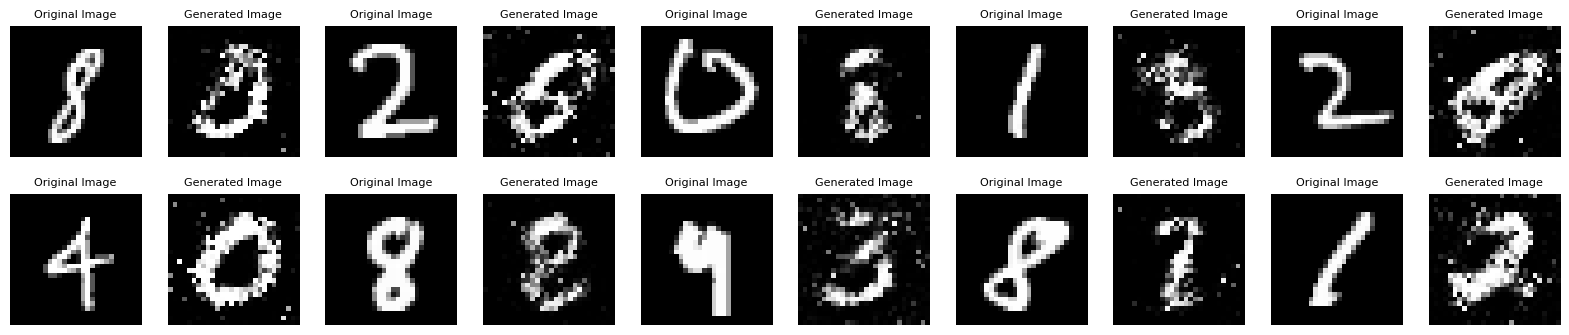

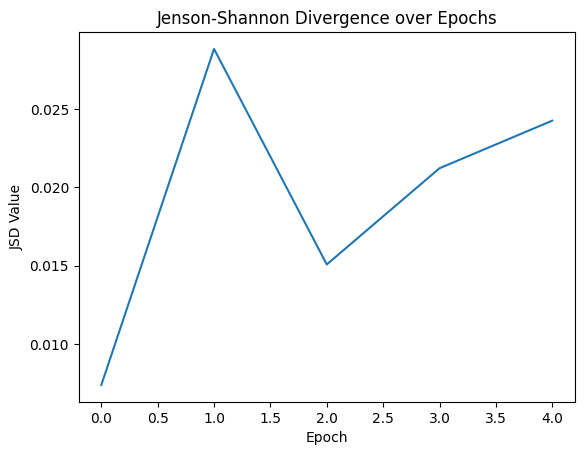

With latent_dim=100 and complexity=64


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.5679727792739868] [G loss: 1.2108116149902344] [JSD: [0.0172766]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.5050172805786133] [G loss: 1.4566702842712402] [JSD: [0.02294804]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.5754056572914124] [G loss: 1.0740818977355957] [JSD: [0.02632734]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.6101975440979004] [G loss: 1.2692121267318726] [JSD: [0.03484397]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.6898175477981567] [G loss: 0.9520667791366577] [JSD: [0.03717148]]
1/1 [==============================] - 0s 126ms/step


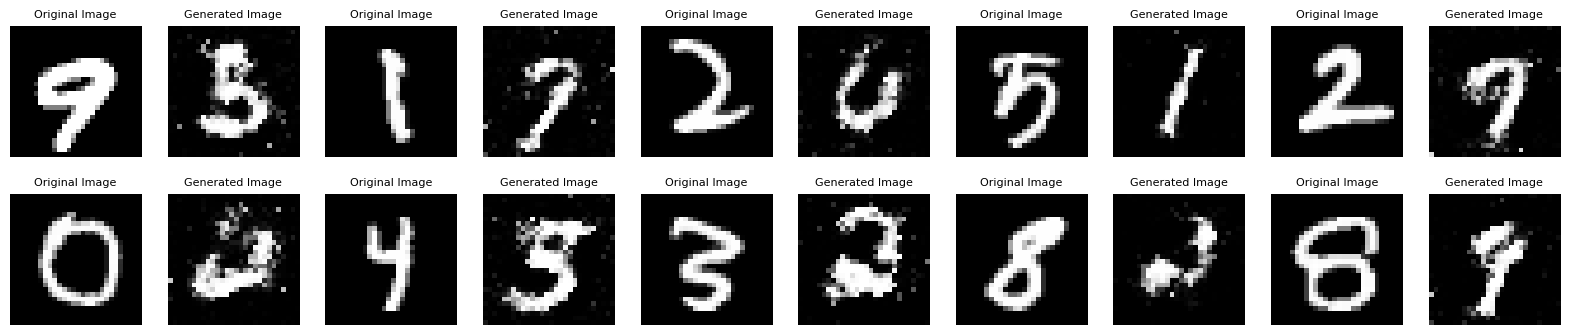

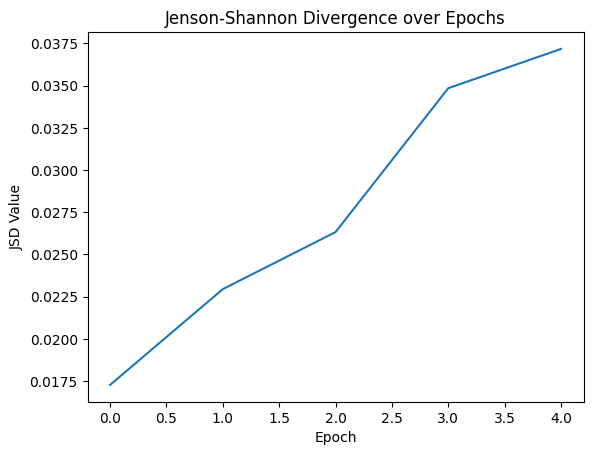

With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.6700135469436646] [G loss: 1.0245184898376465] [JSD: [0.01409035]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.5739312767982483] [G loss: 1.2681429386138916] [JSD: [0.03419292]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6284843683242798] [G loss: 1.447937250137329] [JSD: [0.03931781]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.678444504737854] [G loss: 1.8189444541931152] [JSD: [0.04840793]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.6303298473358154] [G loss: 1.402208924293518] [JSD: [0.04426541]]
1/1 [==============================] - 0s 124ms/step


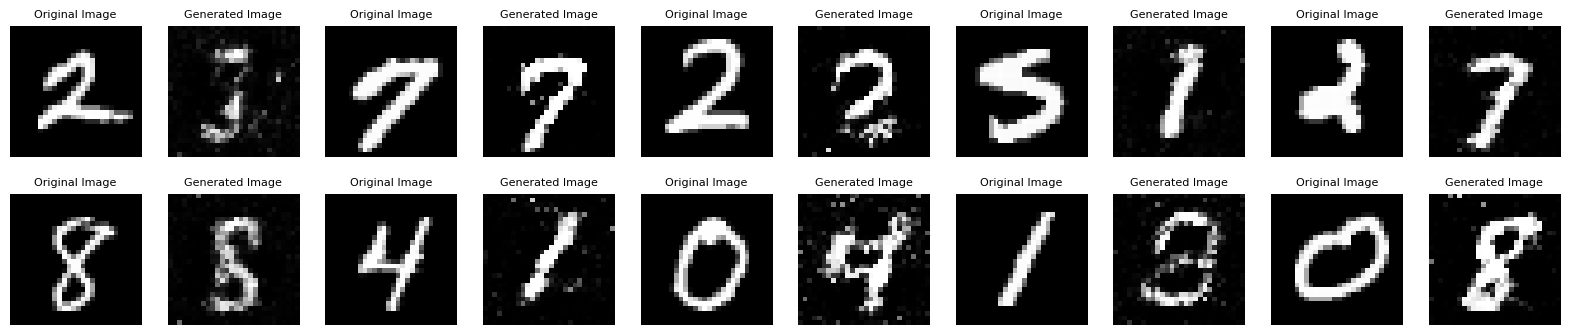

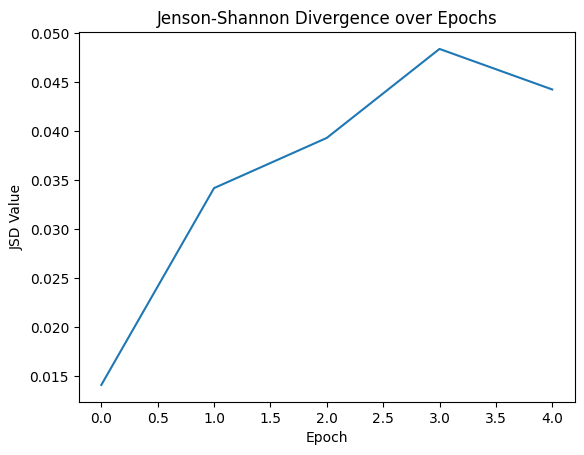

With latent_dim=100 and complexity=256


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.5867315530776978] [G loss: 1.034738302230835] [JSD: [0.00774914]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.6864506006240845] [G loss: 0.8611578345298767] [JSD: [0.01419258]]
4/4 [==============================] - 0s 4ms/step
Epoch 3/5 [D loss: 0.6474711298942566] [G loss: 0.5555380582809448] [JSD: [0.00573257]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.6688776016235352] [G loss: 0.7111250162124634] [JSD: [0.01536967]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6698974967002869] [G loss: 1.4184086322784424] [JSD: [0.01933913]]
1/1 [==============================] - 0s 125ms/step


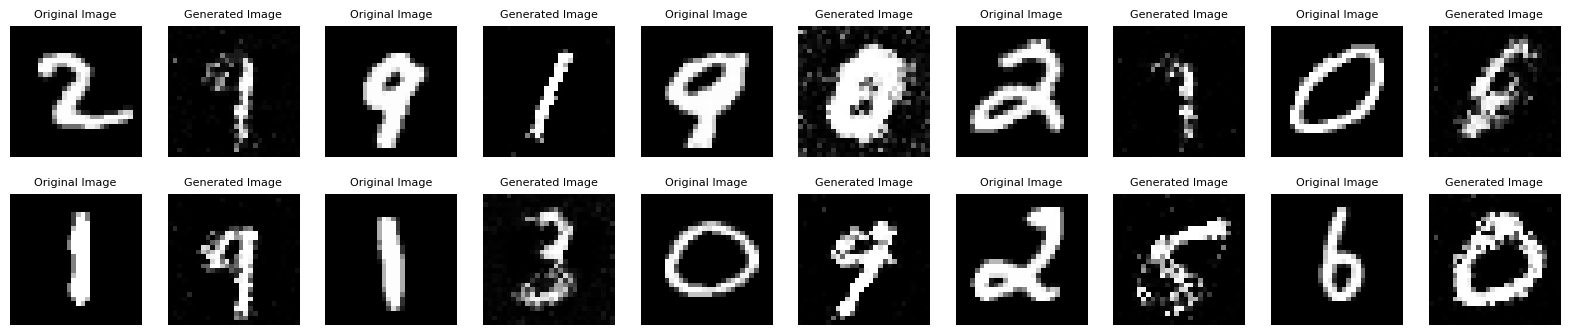

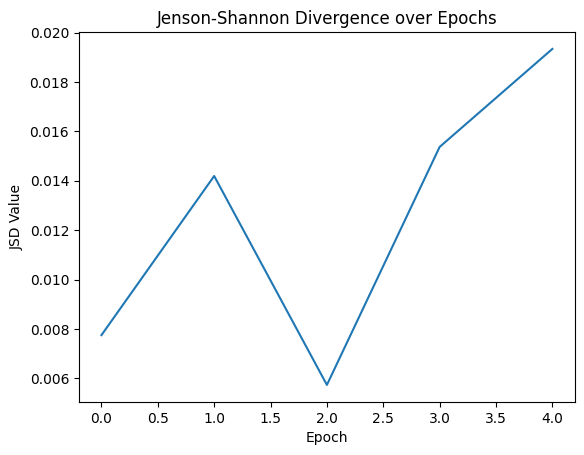

In [9]:
latent_dim = 100
complexity_values = [32, 64, 128, 256]

# Set the image shape for MNIST
img_shape = (28, 28, 1)

for complexity in complexity_values:
    print(f"With latent_dim={latent_dim} and complexity={complexity}")
    generator = build_generator(latent_dim, img_shape,complexity)
    discriminator = build_discriminator(img_shape,complexity)
    gan = build_gan(generator, discriminator)
    generator, jsd_values = train_gan(generator, discriminator, gan, epochs, batch_size)
    plot_original_and_generated_images(generator, epochs, latent_dim)
    plot_jsd_over_epochs(jsd_values)